Dataset path: ~/aiffel/quest/Exploration/Quest01
🔄 저장된 모델이 없습니다. 새로 훈련을 시작합니다...
Epoch 1/10
92/92 [==============================] - 6s 30ms/step - loss: 1.3710 - accuracy: 0.4312 - val_loss: 1.1805 - val_accuracy: 0.5368
Epoch 2/10
92/92 [==============================] - 2s 19ms/step - loss: 1.0543 - accuracy: 0.5749 - val_loss: 1.0379 - val_accuracy: 0.5940
Epoch 3/10
92/92 [==============================] - 2s 19ms/step - loss: 0.9313 - accuracy: 0.6369 - val_loss: 0.9324 - val_accuracy: 0.6267
Epoch 4/10
92/92 [==============================] - 2s 19ms/step - loss: 0.8242 - accuracy: 0.6918 - val_loss: 0.8478 - val_accuracy: 0.6621
Epoch 5/10
92/92 [==============================] - 2s 19ms/step - loss: 0.7259 - accuracy: 0.7299 - val_loss: 0.7825 - val_accuracy: 0.7030
Epoch 6/10
92/92 [==============================] - 2s 19ms/step - loss: 0.6332 - accuracy: 0.7786 - val_loss: 0.7260 - val_accuracy: 0.7275
Epoch 7/10
92/92 [==============================] - 2s 19ms/step - loss: 

20/20 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.7548
✅ 초기 모델 성능 - loss: 0.66, accuracy: 0.75
Feature shape: (32, 5, 5, 512)
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None,

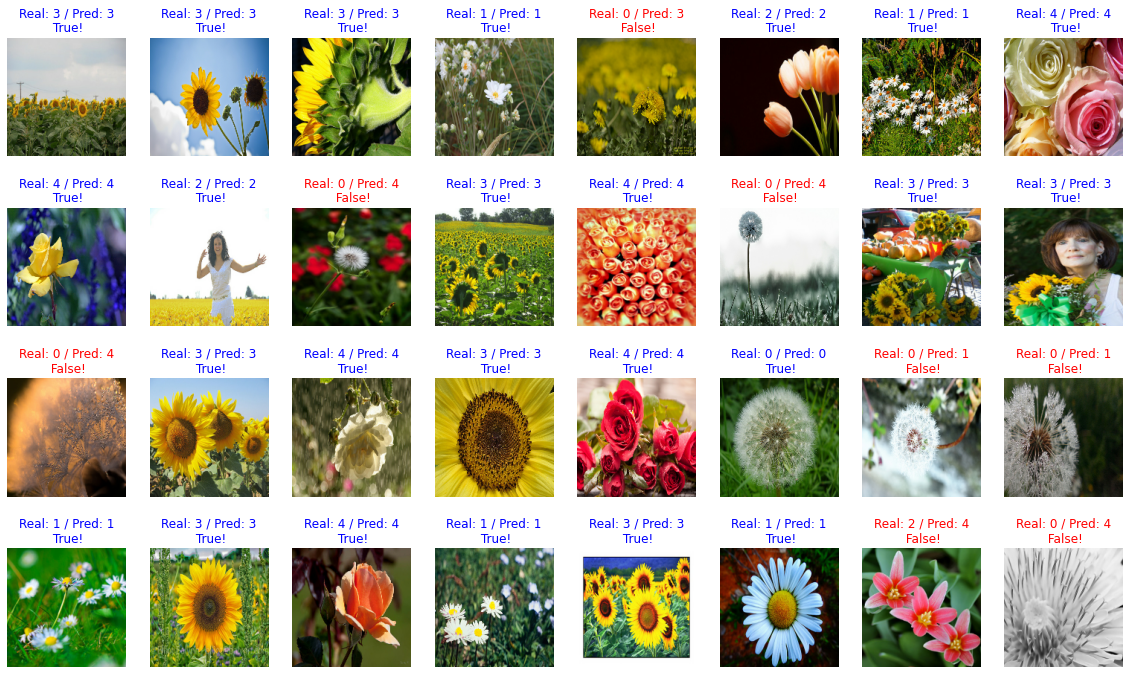

✅ 예측된 배치의 정확도: 75.00%


In [3]:
import tensorflow as tf
import sys
import platform
import os
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import random
from tensorflow.keras.initializers import GlorotUniform

# Windows에서 'resource' 모듈 오류 방지
if platform.system() == "Windows":
    sys.modules["resource"] = None

# 모델 저장 경로
model_save_path = os.path.expanduser("~/aiffel/quest/Exploration/Quest01/flower_model.h5")

# 기존 데이터셋 경로 설정
dataset_path = "~/aiffel/quest/Exploration/Quest01"
print("Dataset path:", dataset_path)

# 데이터셋이 존재하는지 확인
if not os.path.exists(dataset_path):
    print(f"❌ 데이터셋 폴더가 존재하지 않습니다: {dataset_path}")
    print("데이터셋을 수동으로 다운로드하여 해당 폴더에 넣어주세요.")
    exit()  # 프로그램 종료
    
# 데이터셋 로드 (전체 데이터 로드 후 나누기)
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

# 데이터 개수 확인
num_samples = info.splits["train"].num_examples
train_size = int(num_samples * 0.8)
val_size = int(num_samples * 0.1)

# 데이터 섞기 (셔플)
full_dataset = dataset["train"].shuffle(num_samples, seed=42)

# 데이터셋 분할
raw_train = full_dataset.take(train_size)
raw_validation = full_dataset.skip(train_size).take(val_size)
raw_test = full_dataset.skip(train_size + val_size)

# 이미지 전처리 함수
IMG_SIZE = 160

def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # 크기 변경
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # 정규화 (-1 ~ 1)
    return image, label

# 데이터 변환 및 배치 적용
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = raw_train.map(format_example).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).cache()
validation_batches = raw_validation.map(format_example).batch(BATCH_SIZE).cache()
test_batches = raw_test.map(format_example).batch(BATCH_SIZE).cache()

# **모델이 존재하면 로드, 없으면 학습 후 저장**
if os.path.exists(model_save_path):
    print("✅ 저장된 모델을 찾았습니다. 모델을 로드합니다...")
    model = tf.keras.models.load_model(model_save_path)
else:
    print("🔄 저장된 모델이 없습니다. 새로 훈련을 시작합니다...")

    # **모델 생성**
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(160, 160, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')  # 5개의 클래스 분류
    ])

    # **모델 컴파일**
    learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    # **모델 학습**
    EPOCHS = 10

    history = model.fit(train_batches,
                        epochs=EPOCHS,
                        validation_data=validation_batches)

    # **모델 저장**
    model.save(model_save_path, save_format="h5")
    print(f"✅ 새로운 모델을 훈련 후 저장했습니다: {model_save_path}")

    model2 = tf.keras.models.load_model(model_save_path)

    # ✅ 올바른 데이터 가져오기
    sample_images, _ = next(iter(test_batches))  # 배치 차원 유지됨

    # ✅ 모델 예측 (Dropout 비활성화)
    pred1 = model.predict(sample_images)
    pred2 = model2.predict(sample_images)

    print("✅ 모델 로드 후 일관성 확인:", np.allclose(pred1, pred2, atol=1e-5))

# **모델 평가**
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps, verbose=1)

print(f"✅ 초기 모델 성능 - loss: {loss0:.2f}, accuracy: {accuracy0:.2f}")

# **VGG16을 사용한 Feature Extraction**
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

feature_batch = base_model(next(iter(train_batches))[0])
print("Feature shape:", feature_batch.shape)

print(base_model.summary())

# **Flattening 변환 테스트**
image = np.array([[1, 2], [3, 4]])
flattened_image = image.flatten()

print("Original shape:", image.shape)
print("Flattened shape:", flattened_image.shape)

# **Global Average Pooling 적용**
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

print("✅ 모든 과정 완료!")


# **테스트 데이터에서 배치 하나 가져오기**
for image_batch, label_batch in test_batches.take(1):
    images = image_batch.numpy()  # NumPy 배열로 변환
    labels = label_batch.numpy()
    predictions = model.predict(image_batch)
    break  # 첫 번째 배치만 가져오기

# **예측 결과 처리**
predictions = np.argmax(predictions, axis=1)

# **예측 결과 시각화**
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx + 1)
    image = (image + 1) / 2  # 정규화된 이미지 다시 복원
    plt.imshow(image)
    correct = (label == prediction)
    title = f'Real: {label} / Pred: {prediction}\n {correct}!'

    # 정답이면 파란색, 오답이면 빨간색 표시
    plt.title(title, fontdict={'color': 'blue' if correct else 'red'})
    plt.axis('off')

plt.show()

# **정확도 계산**
correct_count = sum(label == prediction for label, prediction in zip(labels, predictions))
accuracy = (correct_count / len(labels)) * 100
print(f"✅ 예측된 배치의 정확도: {accuracy:.2f}%")